In [4]:
from pathlib import Path
import sys
PROJECT_ROOT = Path(r"C:\Users\luigu\OneDrive\Escritorio\ProyectoML_YouTube")
sys.path.append(str(PROJECT_ROOT))

DATA_PATH = PROJECT_ROOT / "data" / "youtube_data.csv"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import networkx as nx

from src.preprocessing import (
    build_model_frame,
    make_preprocessor_unsupervised,
    make_tfidf_only,
    prepare_graph_for_greedy
)
from src.evaluation import kmeans_silhouette, top_terms_by_groups
from src.visualization import line_xy, bar_counts, scatter_2d

In [5]:
df_raw = pd.read_csv(DATA_PATH, low_memory=False)
df = build_model_frame(df_raw)
print("Shape df:", df.shape)
df[["title","category","duration_sec","title_len","title_words","tag_count"]].head(5)

Shape df: (17589, 25)


,title,category,duration_sec,title_len,title_words,tag_count
0,«السودان ينتفض» أمام السفارة بالقاهرة,News & Politics,180.0,37,5,47
1,Pokemon Tower Defense Episodio 2,Gaming,930.0,34,5,5
2,New Hip Hop - Kemo Treats - Pancakes,Comedy,233.0,36,8,37
3,Sister's Keeper Impression,People & Blogs,562.0,26,3,6
4,JBHAMMER777 (AKUMA) VS KtossPol Rank 1 (Vega)...,Gaming,300.0,76,14,55


In [6]:
pre_unsup = make_preprocessor_unsupervised(
    include_numeric=True,
    include_categorical=True,
    include_title_tfidf=True,
    include_hashtags_tfidf=False,
    svd_components=120   # si tu máquina va justa, usa 80–100
)
X = pre_unsup.fit_transform(df)
X.shape

(17589, 120)

c:\Users\luigu\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\luigu\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\luigu\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\luigu\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

,k,silhouette
4,10,0.171384
3,9,0.168708
2,8,0.160238
1,7,0.158013
0,6,0.157034
5,11,0.149894
6,12,0.140268


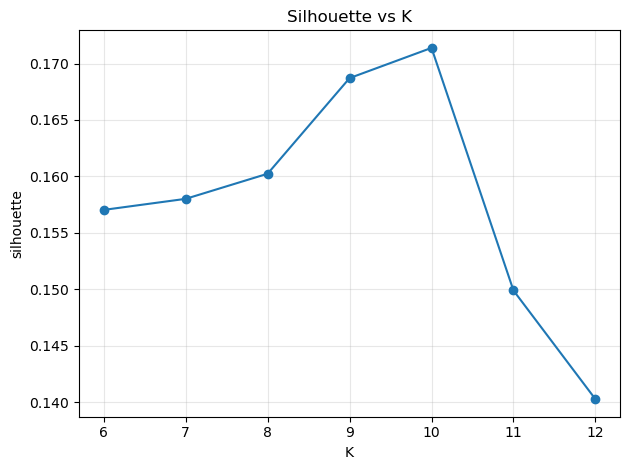

In [7]:
Ks = [6,7,8,9,10,11,12]
scores = []
for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X)
    sil = kmeans_silhouette(X, labels)
    scores.append({"k": k, "silhouette": sil})

scores_df = pd.DataFrame(scores)
display(scores_df.sort_values("silhouette", ascending=False))

line_xy(scores_df["k"], scores_df["silhouette"], title="Silhouette vs K", xlabel="K", ylabel="silhouette")
plt.show()

K elegido: 10


,count
0,2882
1,1330
2,4705
3,2076
4,157
5,704
6,2802
7,3
8,1339
9,1591


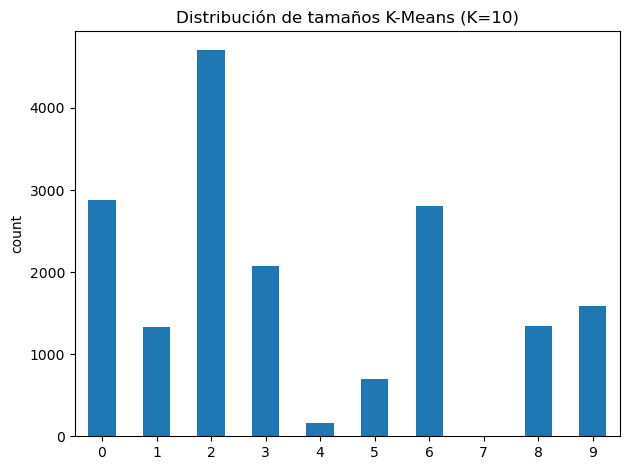

In [8]:
best_k = int(scores_df.sort_values("silhouette", ascending=False).iloc[0]["k"])
km = KMeans(n_clusters=best_k, n_init=10, random_state=42)
labels_km = km.fit_predict(X)

sizes = pd.Series(labels_km).value_counts().sort_index()
print("K elegido:", best_k)
display(sizes.to_frame("count"))
bar_counts(sizes, f"Distribución de tamaños K-Means (K={best_k})", ylabel="count")
plt.show()

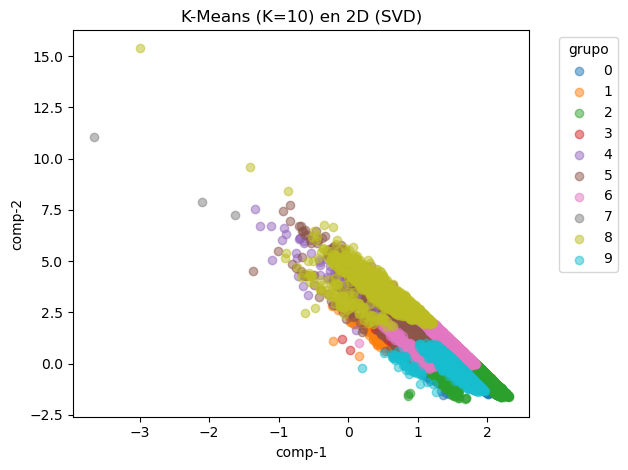

In [9]:
svd2 = TruncatedSVD(n_components=2, random_state=42)
X2 = svd2.fit_transform(X)
scatter_2d(X2, labels=labels_km, title=f"K-Means (K={best_k}) en 2D (SVD)")
plt.show()

In [10]:
vec_title = make_tfidf_only(column="title", min_df=10)
X_tfidf = vec_title.fit_transform(df["title"].fillna("").astype(str))
terms_km = top_terms_by_groups(vec_title, X_tfidf, labels_km, topn=15)
terms_km.head(10)

,group,size,top_terms
0,2,4705,"avi, mov, the, wmv, video, de, mvi, my, in, en..."
1,0,2882,"wmv, de, the, video, my, avi, in, and, la, cov..."
2,6,2802,"de, the, in, at, on, and, of, vs, to, video, e..."
3,3,2076,"the, de, by, cover, and, of, in, la, vs, video..."
4,9,1591,"part, wmv, the, de, video, vs, of, flv, my, an..."
5,8,1339,"de, the, of, and, in, la, to, vs, at, by, for,..."
6,1,1330,"part, de, the, of, vs, in, and, parte, minecra..."
7,5,704,"the, hd, part, in, of, and, de, let, with, pla..."
8,4,157,"the, de, episode, of, full, play, part, and, l..."
9,7,3,"mix, york, yo, years, year old, year, ya, xd, ..."


In [11]:
edges, idx_map = prepare_graph_for_greedy(
    df=df,
    text_col="title",
    min_df=10,
    k=15,
    sim_threshold=0.25
)
print("Nodos:", len(idx_map), "| Aristas:", len(edges))

G = nx.Graph()
G.add_nodes_from(range(len(idx_map)))
for i, j, w in edges:
    G.add_edge(i, j, weight=w)

comms = list(nx.algorithms.community.greedy_modularity_communities(G, weight="weight"))
from networkx.algorithms.community.quality import modularity
Q = modularity(G, comms, weight="weight")
print(f"#Comunidades: {len(comms)} | Modularity Q: {Q:.3f}")

Nodos: 17589 | Aristas: 176196
#Comunidades: 5692 | Modularity Q: 0.732


In [12]:
vec_title_g = make_tfidf_only(column="title", min_df=10)
X_tfidf_g = vec_title_g.fit_transform(df["title"].fillna("").astype(str))

# mapear nodo→comunidad
node2comm = {}
for cid, nodes in enumerate(comms):
    for n in nodes:
        node2comm[n] = cid
labels_comm = np.array([node2comm[i] for i in range(len(idx_map))])

terms_comm = top_terms_by_groups(vec_title_g, X_tfidf_g, labels_comm, topn=15)
terms_comm.head(12)

,group,size,top_terms
0,0,3081,"the, my, me, cover, you, for, of, and, love, i..."
1,1,1964,"part, of, the, day, episode, of the, from, on,..."
2,2,1505,"de, en, el, la, do, del, no, parte, da, con, l..."
3,3,1104,"new, dance, let play, let, show, play, ford, e..."
4,4,687,"at, the, movie, in the, in, dj, park, tour, at..."
5,5,532,"and, on, trailer, ft, video, promo, alex, fire..."
6,6,263,"by, com, intro, youtube, tutorial, wedding, ww..."
7,7,234,"vs, man, goal, og, daniel, iron, mit, performa..."
8,8,233,"to, mi, happy, school, black ops, ops, black, ..."
9,9,168,"live, high, jam, mod, version, karaoke, server..."
